# **Jupyter Notebook: Iterated Prisoner's Dilemma (Example)**
---

## **Code Box 1: Title & Explanation**

**Title**: *Multi-Agent Prisoner's Dilemma with LLM-Generated Strategies*

**Explanation**:  
This notebook demonstrates a simple multi-agent Prisoner’s Dilemma simulation, where each agent’s “strategy” is suggested by an LLM (OpenAI model). We keep the population size small and the number of generations low for easy testing.  

The overall flow follows the structure from the research proposal:

1. **Initialize Parameters**  
   - Choose LLM type (OpenAI)  
   - Game mechanics (Prisoner’s Dilemma payoffs)  
   - Evolution parameters (how many generations, how many agents survive, etc.)

2. **Generation 1: Create initial agents**  
   - Use LLM to generate a short text description or “policy” for each agent.  
   - Store these strategies locally.

3. **Play the Donor Game (Prisoner’s Dilemma)**  
   - Pair up agents (for simplicity, we just do random pairings).  
   - Each agent decides to *cooperate* or *defect* based on their “policy.”  
   - Resources (scores) get updated based on PD payoffs.  
   - Track any relevant info (e.g., reputation).

4. **Resource Calculation**  
   - Final scores are tallied.  
   - Data is collected for analysis.

5. **Selection Process**  
   - Top 50% of agents survive (or some survival threshold).  
   - Surviving agents pass on their strategies.

6. **Strategy Transmission**  
   - New agents join to keep population size constant.  
   - The new agents may incorporate or mutate strategies from the surviving agents (again we prompt the LLM to generate text).

7. **Next Generation**  
   - Combine survivors + new agents.  
   - Repeat the cycle if more generations are needed.

8. **Analysis & Storage**  
   - Store results (cooperation rates, final resources, etc.)  
   - Visualize or print basic statistics about the outcomes.

We use OpenAI’s `openai` library for generating strategy descriptions or updates. Make sure you have an API key set up in your environment, e.g. with `export OPENAI_API_KEY="..."` or by adding it directly to `openai.api_key`.

---

In [32]:
# Cell 1: Imports and Client Setup
from openai import OpenAI
import os
import random
import pandas as pd
import json
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Initialize OpenAI client with API key from environment
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Parameters
NUM_AGENTS = 10        # small population for testing
NUM_GENERATIONS = 30   # run a few generations to keep it quick
SURVIVAL_RATE = 0.5   # top 50% survive each generation

In [2]:
# **Code Box 3: Prisoner’s Dilemma Setup & Utility Functions**

# Payoff matrix for Prisoner's Dilemma, typical example:
# Cooperate (C), Defect (D)
# If both cooperate: each gets R (reward)
# If one cooperates & the other defects: cooperator gets S (sucker's payoff), defector gets T (temptation)
# If both defect: each gets P (punishment)

# Let's define numeric values:
R = 3  # Reward
T = 5  # Temptation
S = 0  # Sucker's payoff
P = 1  # Punishment

def play_pd(agent1_action, agent2_action):
    """
    Returns the payoff (score) for agent1, agent2 given their actions 'C' or 'D'.
    """
    if agent1_action == 'C' and agent2_action == 'C':
        return R, R
    elif agent1_action == 'C' and agent2_action == 'D':
        return S, T
    elif agent1_action == 'D' and agent2_action == 'C':
        return T, S
    else:  # D, D
        return P, P

def evaluate_population(agents):
    """
    Pair up agents randomly and have them play the PD game.
    Each agent's 'decide_action()' method determines 'C' or 'D'.
    Returns updated agents with new total scores.
    """
    random.shuffle(agents)
    # In a small population, we can pair them 2 by 2
    for i in range(0, len(agents), 2):
        if i+1 < len(agents):
            a1 = agents[i]
            a2 = agents[i+1]
            action1 = a1.decide_action(a2)
            action2 = a2.decide_action(a1)
            payoff1, payoff2 = play_pd(action1, action2)
            a1.total_score += payoff1
            a2.total_score += payoff2
    return agents

In [28]:
# **Code Box 4: LLM Strategy Generation**

def generate_strategy_description(template_prompt=""):
    """
    Calls OpenAI API (updated version) to generate a Prisoner's Dilemma strategy.
    """

    
    base_prompt = f"""
    You are designing a strategy for playing the Iterated Prisoner's Dilemma game repeatedly.
    Describe concisely how your agent decides to cooperate or defect without mentioning common known strategies.
    Be creative and clear, but do not name specific classic strategies explicitly.
    {template_prompt}
    """


    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": base_prompt}],
            temperature=0.7,
            max_tokens=100
        )
        strategy_text = response.choices[0].message.content.strip()
        return strategy_text
    except Exception as e:
        print("OpenAI API Error:", e)
        return "Always Defect"

In [33]:
# Cell 2: EnhancedAgent Class Definition
class EnhancedAgent:
    def __init__(self, name):
        self.name = name
        self.total_score = 0
        self.history = []  # Log of (opponent, own_action, opp_action, own_payoff)
        self.strategy_matrix = self.generate_strategy_matrix()

    def generate_strategy_matrix(self):
        prompt = """
        You are defining a strategy for repeatedly playing the Iterated Prisoner's Dilemma. 
        Output a concise strategy matrix clearly stating your action (C or D) based on:
        1. Your previous action
        2. Opponent's previous action
        Format example:
        CC: C
        CD: D
        DC: C
        DD: D
        
        Additionally, write one brief sentence describing your overall reasoning clearly.
        """
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.9,
            max_tokens=100
        )
        return response.choices[0].message.content.strip()

    def decide_action(self, opponent_name):
        history_summary = "\n".join(
            [f"Round {idx+1}: Opponent: {opp}, You: {self_act}, Opponent action: {opp_act}, Your payoff: {payoff}"
             for idx, (opp, self_act, opp_act, payoff) in enumerate(self.history[-3:])]
        ) or "No previous rounds."

        decision_prompt = f"""
        You are playing Iterated Prisoner's Dilemma against '{opponent_name}'.
        Your strategy matrix is:
        {self.strategy_matrix}

        Recent interaction history:
        {history_summary}

        Based on this information, decide your next action. Respond with a single character (C or D) 
        and one brief explanatory sentence explaining your decision.
        """

        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": decision_prompt}],
            temperature=0.7,
            max_tokens=20
        )

        content = response.choices[0].message.content.strip()
        action = content[0].upper() if content and content[0].upper() in ['C', 'D'] else random.choice(['C', 'D'])
        reasoning = content[2:].strip() if len(content) > 2 else "No clear reasoning provided."
        return action, reasoning

    def log_interaction(self, opponent, own_action, opp_action, payoff):
        self.history.append((opponent, own_action, opp_action, payoff))

In [34]:
# Cell 3: Payoff Matrix and Agent Initialization
# Define the payoff matrix
payoff_matrix = {
    ('C', 'C'): (3, 3),
    ('C', 'D'): (0, 5),
    ('D', 'C'): (5, 0),
    ('D', 'D'): (1, 1),
}

# Function to initialize agents
def create_enhanced_agents(n=4):
    return [EnhancedAgent(f"Agent_{i}") for i in range(n)]

In [35]:
# Cell 4: Main Simulation with Detailed Logging
def run_llm_driven_simulation(num_agents=4, num_generations=5):
    agents = create_enhanced_agents(num_agents)
    all_detailed_logs = []

    for gen in range(num_generations):
        print(f"\n=== Generation {gen+1} ===")
        detailed_logs = []
        random.shuffle(agents)

        # Pairwise interactions
        for i in range(0, len(agents), 2):
            if i + 1 < len(agents):
                agent_a, agent_b = agents[i], agents[i+1]

                action_a, reasoning_a = agent_a.decide_action(agent_b.name)
                action_b, reasoning_b = agent_b.decide_action(agent_a.name)

                payoff_a, payoff_b = payoff_matrix[(action_a, action_b)]

                agent_a.total_score += payoff_a
                agent_b.total_score += payoff_b

                agent_a.log_interaction(agent_b.name, action_a, action_b, payoff_a)
                agent_b.log_interaction(agent_a.name, action_b, action_a, payoff_b)

                detailed_logs.append({
                    "Generation": gen+1,
                    "Pair": f"{agent_a.name}-{agent_b.name}",
                    "Actions": f"{action_a}-{action_b}",
                    "Payoffs": f"{payoff_a}-{payoff_b}",
                    "Reasoning_A": reasoning_a,
                    "Reasoning_B": reasoning_b
                })

                print(f"{agent_a.name} vs {agent_b.name}: {action_a}-{action_b}, Payoffs: {payoff_a}-{payoff_b}")

        all_detailed_logs.extend(detailed_logs)

        # Select top agents and reproduce
        agents.sort(key=lambda a: a.total_score, reverse=True)
        top_agents = agents[:num_agents // 2]

        # Mutate and create new agents for the next generation
        new_agents = [EnhancedAgent(f"Agent_{gen+1}_{i}") for i in range(num_agents // 2)]
        agents = top_agents + new_agents

        # Reset scores for next generation
        for agent in agents:
            agent.total_score = 0

    # Save detailed logs in a subfolder
    results_folder = "simulation_results_llm"
    os.makedirs(results_folder, exist_ok=True)
    detailed_df = pd.DataFrame(all_detailed_logs)
    detailed_df.to_csv(os.path.join(results_folder, "detailed_llm_logs.csv"), index=False)
    detailed_df.to_json(os.path.join(results_folder, "detailed_llm_logs.json"), orient="records", indent=4)

    print("\nSimulation completed. Logs saved.")

In [36]:
# Cell 5: Execute the Simulation
# Adjust parameters as desired (e.g., num_agents and num_generations)
run_llm_driven_simulation(num_agents=6, num_generations=5)


=== Generation 1 ===
Agent_3 vs Agent_5: C-C, Payoffs: 3-3
Agent_0 vs Agent_1: C-C, Payoffs: 3-3
Agent_4 vs Agent_2: C-C, Payoffs: 3-3

=== Generation 2 ===
Agent_1_2 vs Agent_5: C-C, Payoffs: 3-3
Agent_1_1 vs Agent_3: C-C, Payoffs: 3-3


KeyboardInterrupt: 

In [6]:
# **Code Box 7: Main Loop / Simulation**

def run_simulation(num_agents=NUM_AGENTS, num_generations=NUM_GENERATIONS):
    agents = create_initial_agents(num_agents)

    for gen in range(num_generations):
        print(f"\n=== Generation {gen+1} ===")
        agents = evaluate_population(agents)

        for a in agents:
            print(f"{a.name}: Strategy='{a.strategy_text}', Score={a.total_score}")

        agents = selection_and_reproduction(agents)

    print("\nFinal Results:")
    for a in agents:
        print(f"{a.name}: {a.strategy_text}, Score={a.total_score}")

if __name__ == "__main__":
    run_simulation()


=== Generation 1 ===
Agent_1: Strategy='One possible strategy could be 'Tit-for-Tat with forgiveness'. This strategy involves starting with cooperation and then mirroring the opponent's previous move in each subsequent round. If the opponent defects, the strategy will defect in the next round as well. However', Score=0
Agent_0: Strategy='One possible strategy could be 'Random', where the player randomly chooses to cooperate or defect in each round of the game. This unpredictable behavior can sometimes lead to surprising outcomes and potentially confuse the opponent's strategy.', Score=5
Agent_3: Strategy='One possible strategy could be 'Random'. In this strategy, the player randomly chooses whether to cooperate or defect in each round of the game. This can add an element of unpredictability to the game and prevent opponents from easily exploiting a consistent pattern of behavior', Score=3
Agent_2: Strategy='One simple strategy for the Iterated Prisoner's Dilemma could be 'Tit-for-Tat'

## **How to Use This Notebook**
1. **Install Requirements**:  
   - `pip install openai`

2. **Set Your API Key**:  
   - Either directly in the code or via an environment variable:  
     ```
     export OPENAI_API_KEY="sk-..."
     ```
3. **Run All Cells**:  
   - The notebook will generate an initial population of Prisoner’s Dilemma agents, each with a strategy text from the LLM.  
   - They will be paired up, play the game, and accumulate scores.  
   - The top 50% survive, then new agents are created via LLM-based “mutations.”  
   - This repeats for the specified number of generations.

4. **Adjust Parameters**:  
   - `NUM_AGENTS` (initial population size)  
   - `NUM_GENERATIONS` (how many times to iterate the process)  
   - `SURVIVAL_RATE` (fraction of agents that survive each generation)

5. **Extend / Modify**:  
   - You can parse strategy texts more cleverly.  
   - You can call the LLM for each action decision (slower, more realistic).  
   - You can store results for deeper analysis, plots, etc.

---

**Note**: This is a **basic** demonstration. In a real research setting, you may wish to:
- Use more advanced prompts for generating or mutating strategies.  
- Implement memory of past encounters.  
- Integrate more sophisticated textual analysis.  
- Incorporate advanced logging and data visualization.

Feel free to adapt as needed!

In [ ]:
%pip install pandas matplotlib

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

print("Pandas version:", pd.__version__)

Pandas version: 2.2.3



=== Generation 1 ===
Agent_0: Strategy='My agent's decision-making process is based on a combination of past interactions and the current state of the game. It calculates the likelihood of the opponent cooperating based on their previous actions and adjusts its own strategy accordingly. Additionally, my agent takes into account the potential benefits of cooperation and the risks of defection in each round, aiming to maximize its overall payoff over the course of multiple iterations. This adaptive approach allows my agent to learn and adapt to the opponent's behavior, making strategic decisions that are tailored to', Score=5
Agent_1: Strategy='My agent uses a combination of observational learning and adaptive decision-making. It starts by cooperating in the first round and then analyzes its opponent's behavior in subsequent rounds. Based on this analysis, my agent adjusts its strategy to either cooperate or defect in order to maximize its own payoff over time. This adaptive approach al

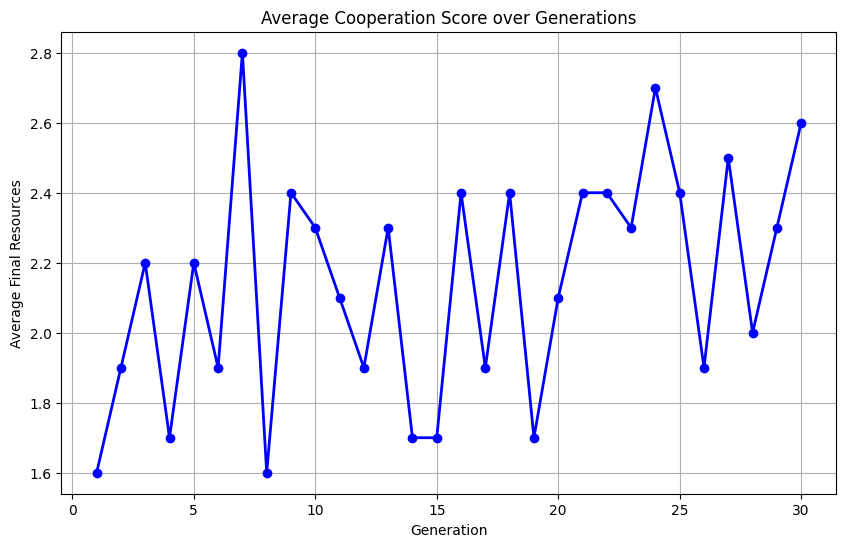


Simulation results saved to: simulation_results/run_2025-03-16_13-32-10


In [31]:
# Additional Cell: Enhanced Logging, Saving, and Visualization in subfolder

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import random
import datetime

# Create main results folder
results_folder = "simulation_results"
os.makedirs(results_folder, exist_ok=True)

# Create a timestamped subfolder for this specific run
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_folder = os.path.join(results_folder, f"run_{current_time}")
os.makedirs(run_folder, exist_ok=True)

# Logging structures
detailed_log = []
generation_summary = []

# Detailed Logging Function
def log_round(gen, round_num, donor, recipient, action_donor, action_recipient, payoff_donor, payoff_recipient, reasoning_donor):
    detailed_log.append({
        "Generation": gen,
        "Round": round_num,
        "Donor": donor.name,
        "Recipient": recipient.name,
        "Donor_Strategy": donor.strategy_text,
        "Recipient_Strategy": recipient.strategy_text,
        "Donor_Action": action_donor,
        "Recipient_Action": action_recipient,
        "Donor_Payoff": payoff_donor,
        "Recipient_Payoff": payoff_recipient,
        "Donor_Total_Score": donor.total_score,
        "Recipient_Total_Score": recipient.total_score,
        "Donor_Reasoning": reasoning_donor
    })

# Generation Summary Logging Function
def log_generation_summary(gen, agents):
    avg_resources = sum(a.total_score for a in agents) / len(agents)
    strategies = [a.strategy_text for a in agents]
    generation_summary.append({
        "Generation": gen,
        "Average_Resources": avg_resources,
        "Agent_Strategies": strategies
    })

# Save Logs to CSV and JSON (in run_folder)
def save_logs():
    # Save run parameters
    params = {
        "NUM_AGENTS": NUM_AGENTS,
        "NUM_GENERATIONS": NUM_GENERATIONS,
        "SURVIVAL_RATE": SURVIVAL_RATE,
        "PD_PAYOFFS": {
            "R": R,
            "T": T,
            "S": S,
            "P": P
        },
        "timestamp": current_time
    }
    
    with open(os.path.join(run_folder, "parameters.json"), 'w') as f:
        json.dump(params, f, indent=4)
    
    # Save detailed logs
    detailed_df = pd.DataFrame(detailed_log)
    detailed_df.to_csv(os.path.join(run_folder, "detailed_logs.csv"), index=False)
    detailed_df.to_json(os.path.join(run_folder, "detailed_logs.json"), orient="records", indent=4)

    # Save generation summary
    summary_df = pd.DataFrame(generation_summary)
    summary_df.to_csv(os.path.join(run_folder, "generation_summary.csv"), index=False)
    summary_df.to_json(os.path.join(run_folder, "generation_summary.json"), orient="records", indent=4)

# Evaluation Metric Plotting
def plot_cooperation_over_time():
    generations = [entry["Generation"] for entry in generation_summary]
    avg_resources = [entry["Average_Resources"] for entry in generation_summary]

    plt.figure(figsize=(10, 6))
    plt.plot(generations, avg_resources, marker='o', linestyle='-', linewidth=2, color='blue')
    plt.title("Average Cooperation Score over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Average Final Resources")
    plt.grid(True)
    plt.savefig(os.path.join(run_folder, "cooperation_over_generations.png"))
    plt.show()

# Main Simulation function (with logging)
def run_simulation_with_logging(num_agents=NUM_AGENTS, num_generations=NUM_GENERATIONS):
    detailed_log.clear()
    generation_summary.clear()

    agents = create_initial_agents(num_agents)

    for gen in range(num_generations):
        print(f"\n=== Generation {gen+1} ===")

        round_num = 1
        random.shuffle(agents)
        for i in range(0, len(agents), 2):
            if i + 1 < len(agents):
                donor, recipient = agents[i], agents[i+1]
                donor_action = donor.decide_action(recipient)
                recipient_action = recipient.decide_action(donor)
                payoff_donor, payoff_recipient = play_pd(donor_action, recipient_action)
                donor.total_score += payoff_donor
                recipient.total_score += payoff_recipient

                # Simulated detailed reasoning from LLM
                reasoning_donor = f"Following strategy: '{donor.strategy_text}', I chose action: '{donor_action}'"
                
                log_round(gen+1, round_num, donor, recipient, donor_action, recipient_action,
                          payoff_donor, payoff_recipient, reasoning_donor)
                round_num += 1

        # Log summary at generation end
        log_generation_summary(gen+1, agents)

        # Interim generation results
        agents.sort(key=lambda x: x.total_score, reverse=True)
        for a in agents:
            print(f"{a.name}: Strategy='{a.strategy_text}', Score={a.total_score}")

        # Proceed with selection and reproduction
        agents = selection_and_reproduction(agents)

    # Save logs and produce visualizations
    save_logs()
    plot_cooperation_over_time()
    
    # Print location of saved results
    print(f"\nSimulation results saved to: {run_folder}")

# Execute the new extended logging simulation
run_simulation_with_logging()